# AA2 - TP1: Ej3


### Descripción:

En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de
todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales
convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.

El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en
seis categorías:
* buildings
* forest
* glacier
* mountain
* sea
* street

Las imágenes están divididas en tres conjuntos:
* Train: Alrededor de 14,000 imágenes para entrenamiento.
* Test: Alrededor de 3,000 imágenes para evaluación del modelo.
* Prediction: Alrededor de 7,000 imágenes para predicción final.

## Carga de librerias y dataset

In [ ]:
# Carga dataset
import gdown
import zipfile
import os

# Librerias básicas y EDA
import pandas as pd
import numpy as np

# Visualizaciones
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import seaborn as sns

# Escaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, GlobalMaxPooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Input, Concatenate, Flatten, BatchNormalization, Add, Activation, GlobalAveragePooling2D
from keras.layers import Dense, Conv2D, MaxPooling2D, Rescaling, RandomFlip, RandomTranslation, RandomContrast

Establecer GPU por defecto en caso de estar disponible.

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


Carga del dataset

In [ ]:
# ID del archivo en Drive
file_id = "13dl6CstH4BlSX-dQkpMGcg5w6Mfqi3RZ"  # <-- reemplazá por tu ID
output = "TP1-3-natural-scenes.zip"

# Descargar con gdown
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

# Descomprimir
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("TP1-3-natural-scenes")

# Verificar carpetas
os.listdir("TP1-3-natural-scenes")

Downloading...
From (original): https://drive.google.com/uc?id=13dl6CstH4BlSX-dQkpMGcg5w6Mfqi3RZ
From (redirected): https://drive.google.com/uc?id=13dl6CstH4BlSX-dQkpMGcg5w6Mfqi3RZ&confirm=t&uuid=6a3572e1-a2b1-4e92-a4bc-711056f267cb
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:04<00:00, 73.8MB/s]


['seg_test', 'seg_train', 'seg_pred']

In [ ]:
# Estructura de directorios

# TP1-3-natural-scenes
#  ├── seg_train
#  │    └── seg_train
#  │         ├── building
#  │         ├── forest
#  │         ├── glacier
#  │         ├── mountain
#  │         ├── sea
#  │         └── street
#  ├── seg_test
#  │    └── seg_test
#  │         ├── building
#  │         ├── forest
#  │         ├── glacier
#  │         ├── mountain
#  │         ├── sea
#  │         └── street
#  └── seg_pred
#       └── seg_pred
#            ├── imagen1.jpg
#            ├── imagen2.jpg
#            ├── ...

In [ ]:
# Directorio base
DATA_DIRECTORY = "/content/TP1-3-natural-scenes"

# Parámetros
BATCH_SIZE = 64
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Tamaño de las imágenes
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

# Epochs
EPOCHS = 30

In [ ]:
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY + "/seg_train/seg_train",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY + "/seg_test/seg_test",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

pred_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY + "/seg_pred/seg_pred",
    labels=None,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

print("\nClases detectadas en train:", train_ds_raw.class_names)
print("Clases detectadas en test:", test_ds_raw.class_names)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 7301 files.

Clases detectadas en train: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Clases detectadas en test: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
# Número de clases
class_names = train_ds_raw.class_names
num_classes = len(class_names)

# Callback
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="min")

In [ ]:
# --- Normalización ---
# Creamos una capa que escala todos los píxeles de las imágenes
# de rango [0, 255] (uint8) a [0, 1] (float32).
# Las redes neuronales convergen mejor cuando los datos están normalizados.
normalization_layer = tf.keras.layers.Rescaling(1./255)

# --- Dataset de entrenamiento ---
train_ds = (
    train_ds_raw
    # Aplica la normalización a cada batch de imágenes (x), dejando igual las etiquetas (y)
    .map(lambda x, y: (normalization_layer(x), y))
    # Guarda los datos procesados en memoria tras la primera pasada (más rápido en epochs siguientes)
    .cache()
    # Baraja aleatoriamente 1000 ejemplos en cada epoch (mejora la generalización)
    .shuffle(1000)
    # Prepara los siguientes batches en paralelo mientras la GPU entrena (optimización de performance)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# --- Dataset de test ---
test_ds = (
    test_ds_raw
    .map(lambda x, y: (normalization_layer(x), y))
    .cache()  # Igual que validación, no se baraja
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# --- Dataset de predicción ---
pred_ds = (
    pred_ds_raw
    # En este caso no hay etiquetas (solo imágenes), por eso la lambda recibe solo x
    .map(lambda x: normalization_layer(x))
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Visualización de imagenes de ejemplo

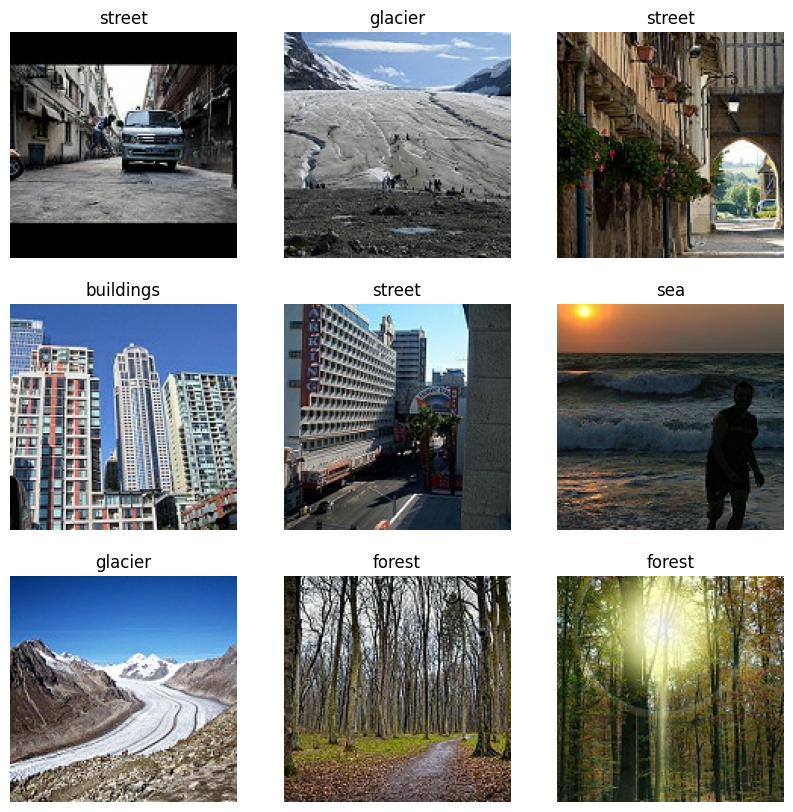

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # Mostrar la imagen normalizada
    plt.imshow(images[i].numpy())
    class_idx = tf.argmax(labels[i]).numpy()
    plt.title(train_ds_raw.class_names[class_idx])
    plt.axis("off")


In [ ]:
# Función para plotear el accuracy y el loss de los modelos

def plot_history(history, model_name="Modelo"):
    acc = history.history['accuracy']
    loss = history.history['loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Entrenamiento')
    plt.title(f'Accuracy - {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro-', label='Entrenamiento')
    plt.title(f'Loss - {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

## Modelo de capas densas

Definir la arquitectura de la red

In [ ]:
# Construcción del modelo
dnn_model = Sequential([
    Flatten(input_shape=input_shape),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Construir el modelo

In [ ]:
# Compilación
dnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Resumen del modelo

In [ ]:
dnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │     8,640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,648,774 (32.99 MB)

 Trainable params: 8,648,774 (32.99 MB)

 Non-trainable params: 0 (0.00 B)

Entrenar el modelo

In [ ]:
dnn_history = dnn_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3394 - loss: 6.3356 - val_accuracy: 0.4450 - val_loss: 2.2582
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4536 - loss: 1.7276 - val_accuracy: 0.4547 - val_loss: 1.6515
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4942 - loss: 1.4460 - val_accuracy: 0.4923 - val_loss: 1.5483
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5448 - loss: 1.2396 - val_accuracy: 0.4530 - val_loss: 1.5693
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5412 - loss: 1.2530 - val_accuracy: 0.5047 - val_loss: 1.3325
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5755 - loss: 1.1498 - val_accuracy: 0.4917 - val_loss: 1.4806
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5826 - loss: 1.1290 - val_accuracy: 0.5460 - val_loss: 1.2165
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6009 - loss: 1.0754 - val_accuracy: 0

Visualizar resultados de entrenamiento

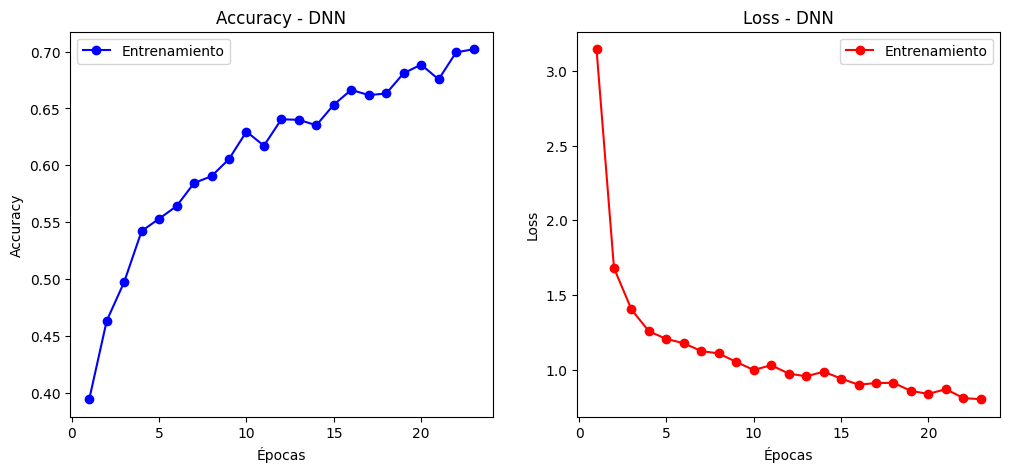

In [ ]:
plot_history(dnn_history, "DNN")

Predecir en nuevas imagenes

In [ ]:
test_loss, test_acc = dnn_model.evaluate(test_ds)
print(f"Precisión en test (DNN): {test_acc:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5052 - loss: 1.4929
Precisión en test (DNN): 0.5060


## Modelo con capas convolucionales y densas

Definir la arquitectura de la red

In [ ]:
def build_cnn(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    ## x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(i)
    x = RandomFlip("vertical")(x)    # Flip vertical aleatorio
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)  # Traslación
    x = RandomContrast(0.2)(x)  # Aumenta/reduce contraste

    x = Conv2D(32, (3,3), padding="same", activation="relu")(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = MaxPooling2D((2,2))(x)

    # Reemplazo Flatten por GlobalAveragePooling2D
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = Dense(64, activation="relu")(x)

    x = Dropout(0.2)(x)
    x = Dense(output_labels, activation="softmax")(x)

    return Model(inputs=[i], outputs=[x])


Construir el modelo

In [ ]:
# Construcción del modelo
cnn_model = build_cnn(input_shape, num_classes)

# Compilación
cnn_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Resumen del modelo

In [ ]:
cnn_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_4 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_5 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 150, 150, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,894 (398.02 KB)

 Trainable params: 101,894 (398.02 KB)

 Non-trainable params: 0 (0.00 B)

Entrenar el modelo

In [ ]:
cnn_history = cnn_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.3703 - loss: 1.4716 - val_accuracy: 0.5397 - val_loss: 1.1314
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5387 - loss: 1.1108 - val_accuracy: 0.5807 - val_loss: 0.9825
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5971 - loss: 0.9927 - val_accuracy: 0.6657 - val_loss: 0.8586
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6391 - loss: 0.9043 - val_accuracy: 0.6787 - val_loss: 0.8345
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6641 - loss: 0.8518 - val_accuracy: 0.6760 - val_loss: 0.7920
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6620 - loss: 0.8471 - val_accuracy: 0.7147 - val_loss: 0.7476
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6893 - loss: 0.8051 - val_accuracy: 0.7160 - val_loss: 0.7546
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7079 - loss: 0.7620 - 

Visualizar resultados de entrenamiento

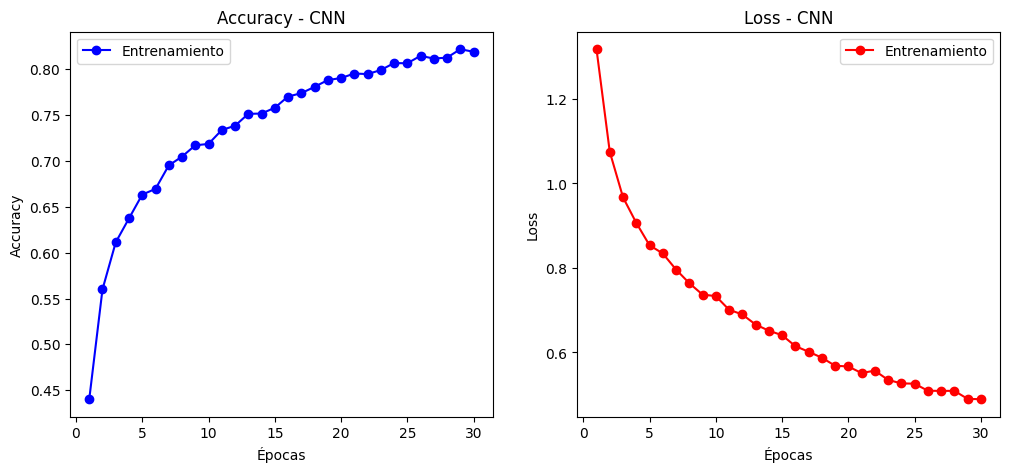

In [ ]:
plot_history(cnn_history, "CNN")

Predecir en nuevas imagenes

In [ ]:
test_loss, test_acc = cnn_model.evaluate(test_ds)
print(f"Precisión en test (light CNN): {test_acc:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8269 - loss: 0.4692
Precisión en test (light CNN): 0.8317


## Modelo con bloques residuales identidad (resnet)

Definir la arquitectura de la red

In [ ]:
# --- Bloque residual básico ---
def residual_block(x, filters, downsample=False):
    shortcut = x

    # 1ra convolución
    stride = 2 if downsample else 1
    x = Conv2D(filters, (3, 3), strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # 2da convolución
    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)

    # Ajustamos el atajo si hay cambio de tamaño
    if downsample or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding="same")(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Suma residual
    x = Add()([shortcut, x])
    x = Activation("relu")(x)
    return x

In [ ]:
# --- Mini ResNet ---
def build_mini_resnet_model(input_shape, num_classes):
    i = Input(shape=input_shape)

    # Capa inicial
    x = Conv2D(32, (7,7), strides=2, padding="same")(i)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((3,3), strides=2, padding="same")(x)

    # Bloques residuales
    x = residual_block(x, 32)
    x = residual_block(x, 32)

    x = residual_block(x, 64, downsample=True)
    x = residual_block(x, 64)

    # Pooling global y clasificación
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation="softmax")(x)

    return Model(inputs=i, outputs=x)

Construir el modelo

In [ ]:
# Construcción del modelo
mini_resnet_model = build_mini_resnet_model(input_shape, num_classes)

# Compilación
mini_resnet_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Resumen del modelo

In [ ]:
mini_resnet_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 75, 75,    │      4,736 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 75, 75,    │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 38, 38,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 38, 38,    │      9,248 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        128 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 38, 38,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 38, 38,    │      9,248 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        128 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 38, 38,    │          0 │ max_pooling2d_6[… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 38, 38,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 38, 38,    │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 38, 38,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 38, 38,    │      9,248 │ activation_3[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        128 │ conv2d_10[0][0] 

 Total params: 175,430 (685.27 KB)

 Trainable params: 174,470 (681.52 KB)

 Non-trainable params: 960 (3.75 KB)

Entrenar el modelo

In [ ]:
mini_resnet_history = mini_resnet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 27s 65ms/step - accuracy: 0.5356 - loss: 1.1757 - val_accuracy: 0.3783 - val_loss: 1.8917
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7566 - loss: 0.6639 - val_accuracy: 0.5753 - val_loss: 1.3074
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7975 - loss: 0.5615 - val_accuracy: 0.5020 - val_loss: 1.5791
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8232 - loss: 0.4945 - val_accuracy: 0.2403 - val_loss: 5.9348
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8335 - loss: 0.4649 - val_accuracy: 0.7520 - val_loss: 0.7087
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8500 - loss: 0.4305 - val_accuracy: 0.6207 - val_loss: 1.0813
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8543 - loss: 0.4152 - val_accuracy: 0.6623 - val_loss: 1.0927
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8495 - loss: 0.4221 - val_acc

Visualizar resultados de entrenamiento

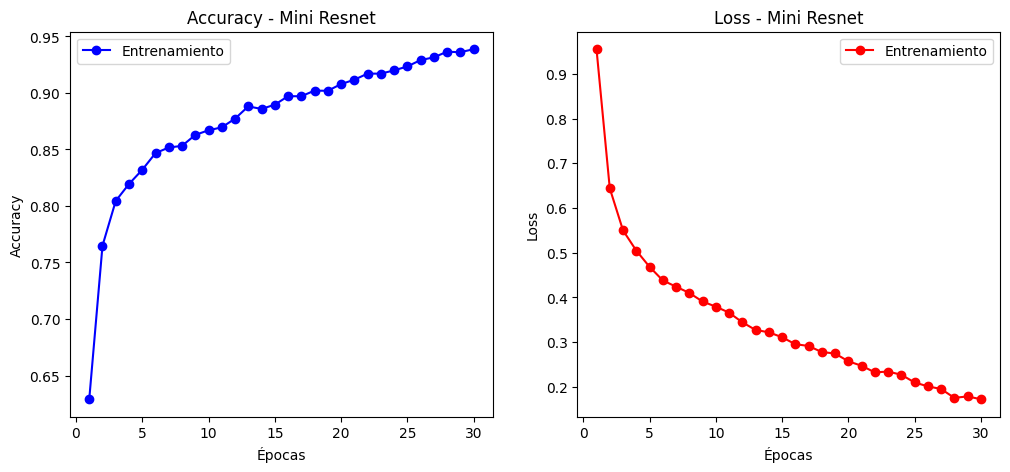

In [ ]:
plot_history(mini_resnet_history, "Mini Resnet")

Predecir en nuevas imagenes

In [ ]:
test_loss, test_acc = mini_resnet_model.evaluate(test_ds)
print(f"Precisión en test (mini_resnet): {test_acc:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8149 - loss: 0.6057
Precisión en test (mini_resnet): 0.8123


## Modelo de transfer learning

Definir la arquitectura de la red

In [ ]:
def build_mobilenet_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation="softmax")(x)

    return tf.keras.Model(i, x)

Construir el modelo

In [ ]:
# Construcción del modelo
mobilenet_model = build_mobilenet_model(input_shape, num_classes)

# Compilación
mobilenet_model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

/tmp/ipython-input-3842931979.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Resumen del modelo

In [ ]:
mobilenet_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Entrenar el modelo

In [ ]:
mobilenet_history = mobilenet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping]
)

Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 49s 148ms/step - accuracy: 0.7507 - loss: 0.6971 - val_accuracy: 0.8937 - val_loss: 0.2813
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8871 - loss: 0.3102 - val_accuracy: 0.8970 - val_loss: 0.2670
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9018 - loss: 0.2691 - val_accuracy: 0.9010 - val_loss: 0.2570
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9037 - loss: 0.2636 - val_accuracy: 0.9053 - val_loss: 0.2454
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9088 - loss: 0.2420 - val_accuracy: 0.9070 - val_loss: 0.2531
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9219 - loss: 0.2182 - val_accuracy: 0.9083 - val_loss: 0.2472
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9204 - loss: 0.2122 - val_accuracy: 0.9067 - val_loss: 0.2440
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9231 - loss: 0.2006 - val_ac

Visualizar resultados de entrenamiento

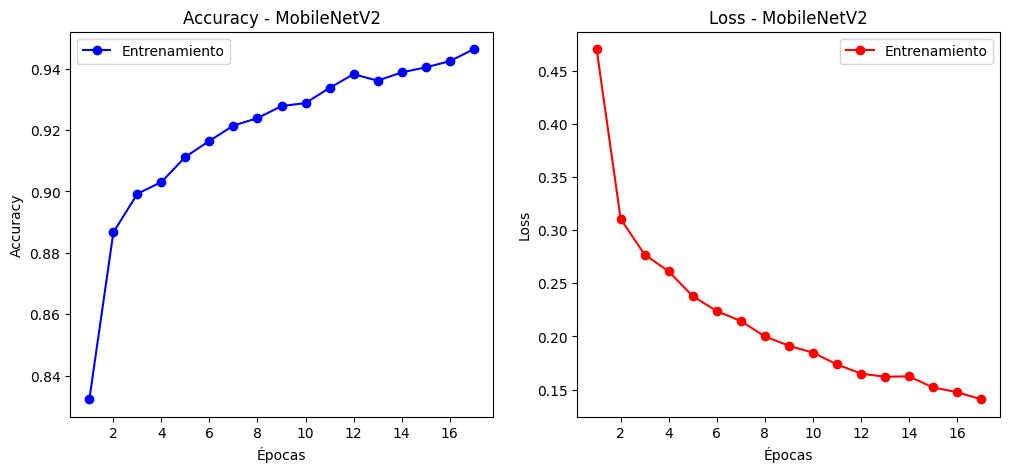

In [ ]:
plot_history(mobilenet_history, "MobileNetV2")

Predecir en nuevas imagenes

In [ ]:
test_loss, test_acc = mobilenet_model.evaluate(test_ds)
print(f"Precisión en test (MobileNetV2): {test_acc:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9070 - loss: 0.2512
Precisión en test (MobileNetV2): 0.9077


## Comparación todos los modelos

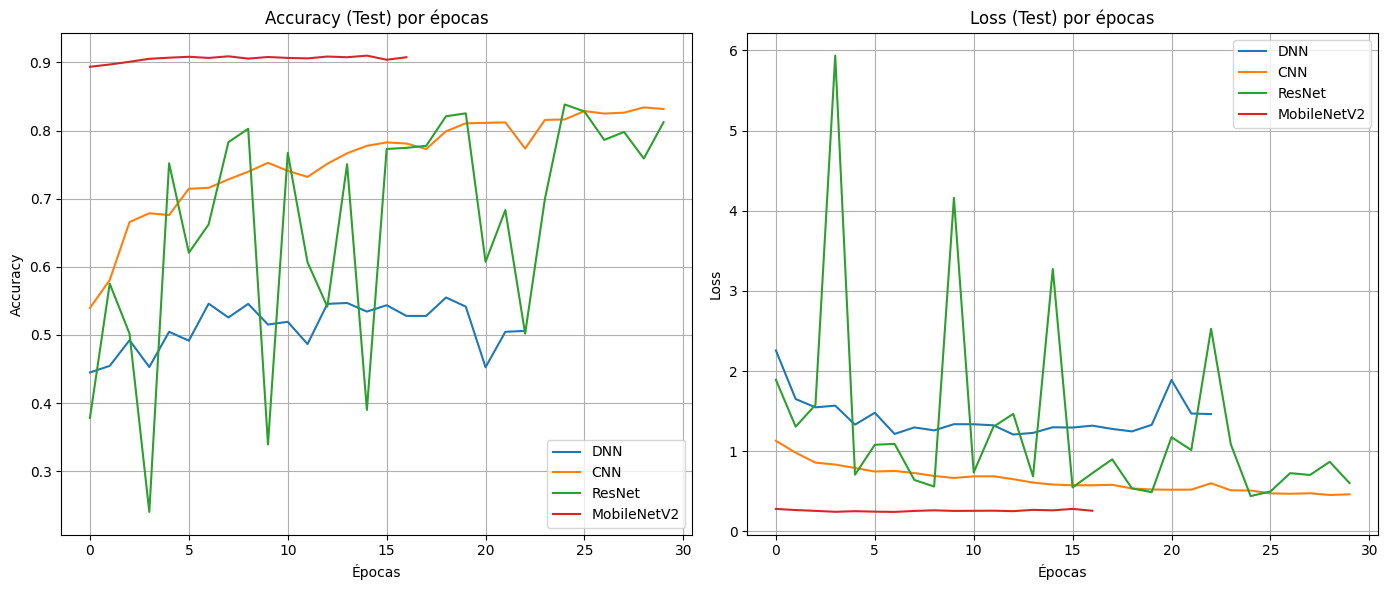

In [ ]:
def compare_test_histories(histories, model_names):
    """
    histories: lista de objetos history de Keras (uno por modelo)
    model_names: lista de nombres de modelos (mismo orden que histories)
    """
    plt.figure(figsize=(14, 6))

    # Accuracy en test
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        if "val_accuracy" in history.history:
            plt.plot(history.history["val_accuracy"], label=f"{name}")
    plt.title("Accuracy (Test) por épocas")
    plt.xlabel("Épocas")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss en test
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        if "val_loss" in history.history:
            plt.plot(history.history["val_loss"], label=f"{name}")
    plt.title("Loss (Test) por épocas")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

compare_test_histories(
    histories=[dnn_history, cnn_history, mini_resnet_history, mobilenet_history],
    model_names=["DNN", "CNN", "ResNet", "MobileNetV2"]
)


In [ ]:
# Predicciones
dnn_preds = dnn_model.predict(pred_ds)
cnn_preds = cnn_model.predict(pred_ds)
resnet_preds = mini_resnet_model.predict(pred_ds)
mobilenet_preds = mobilenet_model.predict(pred_ds)

# Obtener la clase con mayor probabilidad
dnn_labels = tf.argmax(dnn_preds, axis=1).numpy()
cnn_labels = tf.argmax(cnn_preds, axis=1).numpy()
resnet_labels = tf.argmax(resnet_preds, axis=1).numpy()
mobilenet_labels = tf.argmax(mobilenet_preds, axis=1).numpy()

115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step


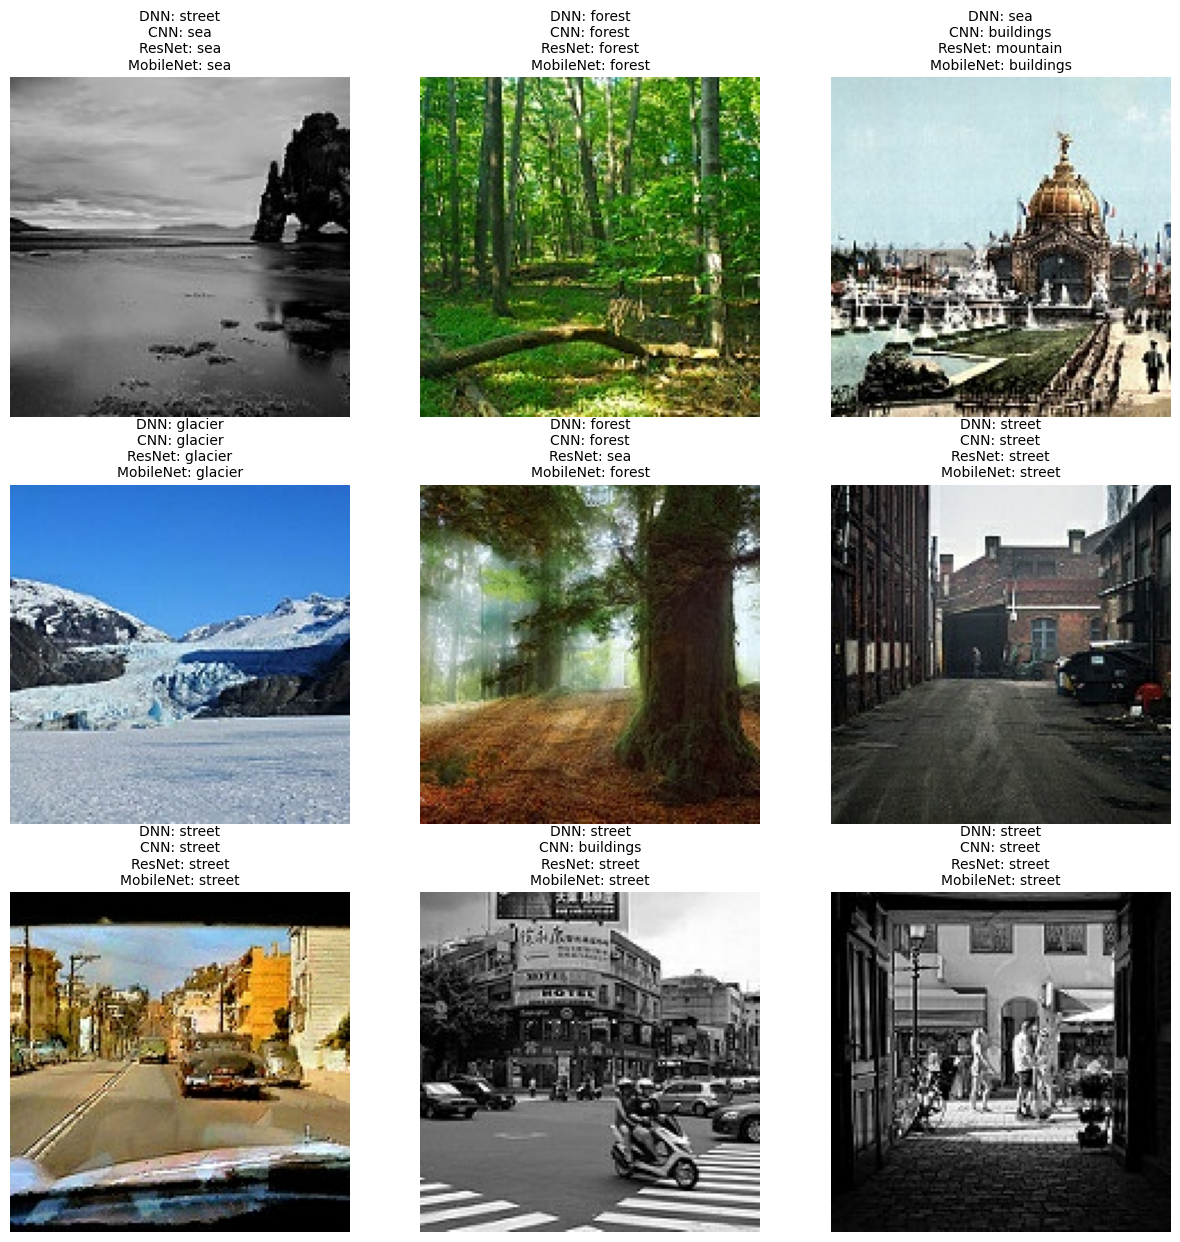

In [ ]:
# Tomamos algunas imágenes de pred_ds
plt.figure(figsize=(15, 15))
for images in pred_ds.take(1):  # solo un batch
    for i in range(9):  # mostramos 9 ejemplos
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis("off")
        plt.title(
            f"DNN: {class_names[dnn_labels[i]]}\n"
            f"CNN: {class_names[cnn_labels[i]]}\n"
            f"ResNet: {class_names[resnet_labels[i]]}\n"
            f"MobileNet: {class_names[mobilenet_labels[i]]}",
            fontsize=10
        )

In [ ]:
# Nombres de las clases
idx_to_class = dict(enumerate(class_names))

# Guardar todas las predicciones
results = {
    "DNN": [idx_to_class[i] for i in dnn_labels],
    "CNN": [idx_to_class[i] for i in cnn_labels],
    "ResNet": [idx_to_class[i] for i in resnet_labels],
    "MobileNet": [idx_to_class[i] for i in mobilenet_labels],
}

df = pd.DataFrame(results)
df.to_csv("comparacion_modelos.csv", index=False)
print("Archivo guardado: comparacion_modelos.csv")

Archivo guardado: comparacion_modelos.csv


In [ ]:
agreement = (dnn_labels == cnn_labels) & (dnn_labels == resnet_labels) & (dnn_labels == mobilenet_labels)
agreement_ratio = agreement.sum() / len(agreement)
print(f"Porcentaje de imágenes donde TODOS los modelos coinciden: {agreement_ratio:.2%}")

Porcentaje de imágenes donde TODOS los modelos coinciden: 43.25%
